NAME: Biruk Bealy
ID:   ATR/1266/10
Section: 2

In [1]:
# 0 Import all the necessary files

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelBinarizer,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,roc_auc_score,plot_roc_curve,auc,roc_curve
from PIL import Image
from imutils import paths
import numpy as np
import os
import random
import shutil
import cv2
import mahotas as mt
import matplotlib.pyplot as plt
import itertools
from sklearn.tree import export_graphviz
import pandas as pd

In [3]:
# 1. Save the features in the form of csv

In [4]:
def extractFeatures(image):
    textures = mt.features.haralick(image)
    ht_mean = textures.mean(axis=0)
    return ht_mean

In [5]:
def fdHistogram(image,mask=None):
    image = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([image],[0,1,2],None,[bins,bins,bins],[0,256,0,256,0,256])
    cv2.normalize(hist,hist)
    return hist.flatten()

In [6]:
def fd_hu_moments(image):
    image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

In [7]:
imagePaths = sorted(list(paths.list_images("dataset")))

random.seed(42)
random.shuffle(imagePaths)
global_feature = []
data = []
labels = []
IMAGE_DIMS = (50,50,1)
bins = 8

In [8]:
for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    image = cv2.resize(image,(IMAGE_DIMS[1],IMAGE_DIMS[0]))
    fv_histogram = fdHistogram(image)
    fv_hu_moments = fd_hu_moments(image)
    features = extractFeatures(image)
    global_feature = np.hstack([fv_histogram,features,fv_hu_moments])
    data.append(global_feature)
    l = label = imagePath.split(os.path.sep)[-2]
    labels.append(l) 
    
lb = LabelEncoder()
label = lb.fit_transform(labels)
print( "Health Status : " ,  lb.classes_)

Health Status :  ['Status_Healthy' 'Status_infected']


In [9]:
df = pd.DataFrame(data)
df.to_csv('data.csv', index = False)
df_file = pd.read_csv('data.csv')
df_file.head()

,0,1,2,3,4,5,6,7,8,9,...,522,523,524,525,526,527,528,529,530,531
0,0.380585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,4.687530,-0.389468,0.991609,0.000927,3.568325e-08,1.258638e-12,6.158524e-14,7.848554e-27,6.004156e-19,-1.524431e-26
1,0.778153,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003626,0.000725,...,3.893610,-0.474808,0.993637,0.001308,2.210277e-07,4.313838e-10,3.658892e-11,3.745708e-21,1.682856e-14,-2.664640e-21
2,0.483936,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,4.752973,-0.398878,0.993179,0.000988,3.986148e-08,1.652247e-11,5.547954e-13,-8.945159e-25,-9.648068e-17,1.421724e-24
3,0.425214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002286,0.002286,...,4.152348,-0.374996,0.988723,0.001005,1.166334e-08,1.651067e-13,1.305053e-13,-3.469470e-27,1.169827e-17,1.884007e-26
4,0.484515,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001589,0.008737,...,3.980872,-0.389100,0.987145,0.001001,7.475556e-09,1.549518e-11,1.517783e-14,-5.960562e-27,-1.289277e-18,-4.318569e-27


In [10]:
## 2. Fit a randomForest model, decision tree,Knn,logistic regression model,linear
#     discriminant analysis,quadratic discriminant analysis, and Boosting algorithm
#     model to the training data

In [11]:
# list of classifiers
models = {
    "random_forest":RandomForestClassifier(n_estimators=100),
    "decision_tree":DecisionTreeClassifier(),
    "knn":KNeighborsClassifier(n_neighbors=1),
    "logit":LogisticRegression(solver="lbfgs",multi_class="auto"),
    "lda":LinearDiscriminantAnalysis(),
    "qda":QuadraticDiscriminantAnalysis(),
    "gradient_boosing": GradientBoostingClassifier(),
}

In [12]:
# Partitioning data into test and training
(trainData, testData, trainLabels, testLabels) = train_test_split(data,labels,test_size=0.5,random_state=0)

In [13]:
# 2.1.1 Random forest model

In [14]:
print(" Training the Model With Random Forest Classifier")
rf = models["random_forest"]
rf.fit(trainData,trainLabels)

 Training the Model With Random Forest Classifier


RandomForestClassifier()

In [15]:
# 2.1.2 Predict the labels for the corresponding test data

In [16]:
print(" Getting a prediction and Generating a classification report") 
predictions = rf.predict(testData)
print(classification_report(testLabels,predictions,target_names=lb.classes_))

 Getting a prediction and Generating a classification report
                 precision    recall  f1-score   support

 Status_Healthy       1.00      1.00      1.00         6
Status_infected       1.00      1.00      1.00         4

       accuracy                           1.00        10
      macro avg       1.00      1.00      1.00        10
   weighted avg       1.00      1.00      1.00        10



In [17]:
# 2.1.3 compute the confusion matrix for the test data

In [18]:
# List of Image Paths.
imagePaths = sorted(list(paths.list_images("testdata")))

random.seed(42)
random.shuffle(imagePaths)
datatest = []
labelstest = []
IMAGE_DIMS = (50,50,1)
print(" Loop over each Image, Pre-Process it, and Store it in the data lists")
for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    image = cv2.resize(image,(IMAGE_DIMS[1],IMAGE_DIMS[0]))
    fv_histogram = fdHistogram(image)
    fv_hu_moments = fd_hu_moments(image)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    features = extractFeatures(image)
    global_feature = np.hstack([fv_histogram,features,fv_hu_moments])
    datatest.append(global_feature)
    labell = imagePath.split(os.path.sep)[-2]
    labelstest.append(labell)

 Loop over each Image, Pre-Process it, and Store it in the data lists


In [19]:
# predicting data and show the report

predictionstest = rf.predict(datatest)
print("Classification Report\n" , classification_report(labelstest,predictionstest,target_names=lb.classes_))

Classification Report
                  precision    recall  f1-score   support

 Status_Healthy       0.54      0.76      0.63      2760
Status_infected       0.60      0.36      0.45      2760

       accuracy                           0.56      5520
      macro avg       0.57      0.56      0.54      5520
   weighted avg       0.57      0.56      0.54      5520



In [20]:
def plot_confusion_matrix(cm,classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=90)
    plt.yticks(tick_marks,classes)
    
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
    
    print(cm)
    
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],horizontalalignment="center",color="white" if cm[i,j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

Confusion matrix, without normalization
[[2098  662]
 [1756 1004]]


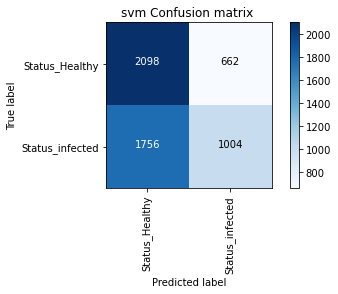

In [21]:
cnf_matrix = confusion_matrix(labelstest,predictionstest)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix,classes=lb.classes_,title='svm Confusion matrix ')
plt.show()

In [22]:
conf_matrix=confusion_matrix(labelstest,predictionstest)
print(conf_matrix)

[[2098  662]
 [1756 1004]]


In [23]:
# 2.1.4 compute AUC for each classifier

In [24]:
target_pred_prob = rf.predict_proba(testData)
rf_auc = roc_auc_score(testLabels,target_pred_prob[:,1], multi_class='ovr')
print(rf_auc)

1.0


In [25]:
# 2.1.5 plot ROC curves as evaluate on the test data

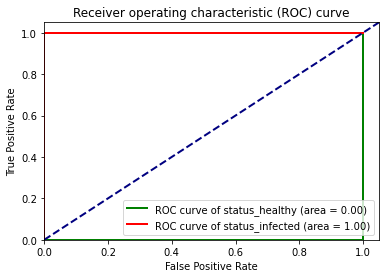

In [26]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(lb.fit_transform(testLabels), target_pred_prob[:, i],pos_label=1)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
colors = ['green', 'red']
targets = ['status_healthy','status_infected']
for i in range(2):
    plt.plot(fpr[i], tpr[i], color=colors[i],
             linewidth=2.0, label='ROC curve of {0} (area = {1:0.2f})'.format(targets[i], roc_auc[i]))
plt.plot([0, 1.05], [0, 1.05], color='navy', linewidth=2.0, linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

In [27]:
# 2.2.1 Decision tree model

In [28]:
# train the model
print("[INFO] using '{}' model".format("decision_tree"))
dt = models["decision_tree"]
dt.fit(trainData,trainLabels)

[INFO] using 'decision_tree' model


DecisionTreeClassifier()

In [29]:
# 2.2.2 Predict the labels for the cooresponding test data

In [30]:
# make predictions on our data and show a classification report
print("[INFO] evaluating...")
predictions = dt.predict(testData)
print(classification_report(testLabels,predictions,target_names=lb.classes_))

[INFO] evaluating...
                 precision    recall  f1-score   support

 Status_Healthy       0.86      1.00      0.92         6
Status_infected       1.00      0.75      0.86         4

       accuracy                           0.90        10
      macro avg       0.93      0.88      0.89        10
   weighted avg       0.91      0.90      0.90        10



In [31]:
# 2.2.3 compute the confusion matrix for the test data

In [32]:
# make predictions on our data and show a classification report
print("[INFO] evluating...")
predictionstest = dt.predict(datatest)
print(classification_report(labelstest,predictionstest,target_names=lb.classes_))

[INFO] evluating...
                 precision    recall  f1-score   support

 Status_Healthy       0.67      0.86      0.75      2760
Status_infected       0.81      0.57      0.67      2760

       accuracy                           0.72      5520
      macro avg       0.74      0.72      0.71      5520
   weighted avg       0.74      0.72      0.71      5520



In [33]:
# Plotting confusion matrix

def plot_confusion_matrix(cm,classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=90)
    plt.yticks(tick_marks,classes)
    
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
    
    print(cm)
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],horizontalalignment="center",color="white" if cm[i,j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')

Confusion matrix, without normalization
[[2379  381]
 [1181 1579]]


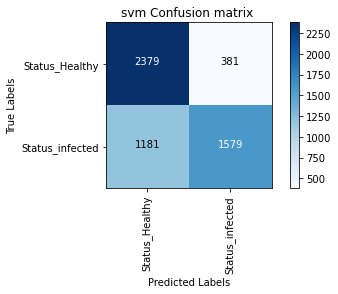

In [34]:
# creating the confusion matrix

cnf_matrix = confusion_matrix(labelstest,predictionstest)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix,classes=lb.classes_,title='svm Confusion matrix ')
plt.show()

In [35]:
# Getting the confusion matrix and predict tests

conf_matrix=confusion_matrix(labelstest,predictionstest)
print("Confusion Matrix\n",conf_matrix)

Confusion Matrix
 [[2379  381]
 [1181 1579]]


In [36]:
# 2.2.4 Compute the Auc for each classifier

In [37]:
target_pred_prob = dt.predict_proba(testData)
dt_auc = roc_auc_score(testLabels,target_pred_prob[:,1], multi_class='ovr')
print(dt_auc)

0.875


In [38]:
# 2.2.5 Plot ROC 

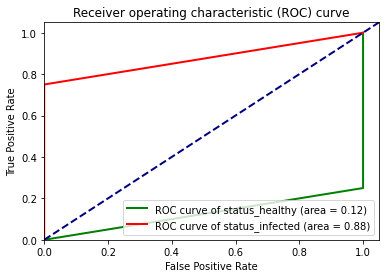

In [39]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(lb.fit_transform(testLabels), target_pred_prob[:, i],pos_label=1)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
colors = ['green', 'red']
targets = ['status_healthy','status_infected']
for i in range(2):
    plt.plot(fpr[i], tpr[i], color=colors[i],
             linewidth=2.0, label='ROC curve of {0} (area = {1:0.2f})'.format(targets[i], roc_auc[i]))
plt.plot([0, 1.05], [0, 1.05], color='navy', linewidth=2.0, linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

In [40]:
# 2.3.1 k-nearest neighbors(KNN) model

In [41]:
print("Training the model with KNN")
knn = models["knn"]
knn.fit(trainData,trainLabels)

Training the model with KNN


KNeighborsClassifier(n_neighbors=1)

In [42]:
# 2.3.2 Predict the labels for the coressponding test data

In [43]:
print("Prediction based on our data and show a classification report")
predictions = knn.predict(testData)
print(classification_report(testLabels,predictions,target_names=lb.classes_))

Prediction based on our data and show a classification report
                 precision    recall  f1-score   support

 Status_Healthy       0.80      0.67      0.73         6
Status_infected       0.60      0.75      0.67         4

       accuracy                           0.70        10
      macro avg       0.70      0.71      0.70        10
   weighted avg       0.72      0.70      0.70        10



In [44]:
# 2.3.3 compute the confusion matrix for the test data

Predictions on our data to show the classification report
                 precision    recall  f1-score   support

 Status_Healthy       0.51      0.70      0.59      2760
Status_infected       0.52      0.32      0.40      2760

       accuracy                           0.51      5520
      macro avg       0.51      0.51      0.49      5520
   weighted avg       0.51      0.51      0.49      5520

Confusion matrix, without normalization
[[1925  835]
 [1873  887]]


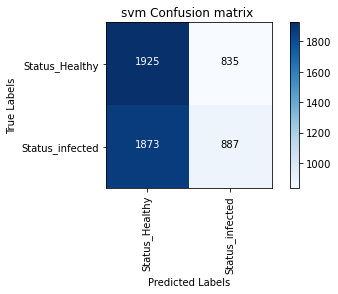

[[1925  835]
 [1873  887]]


In [45]:
print("Predictions on our data to show the classification report")
predictionstest = knn.predict(datatest)
print(classification_report(labelstest,predictionstest,target_names=lb.classes_))

cnf_matrix = confusion_matrix(labelstest,predictionstest)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix,classes=lb.classes_,title='svm Confusion matrix ')
plt.show()

conf_matrix=confusion_matrix(labelstest,predictionstest)
print(conf_matrix)

In [46]:
# 2.3.4 compute the AUC

In [47]:
target_pred_prob = knn.predict_proba(testData)
knn_auc = roc_auc_score(testLabels,target_pred_prob[:,1], multi_class='ovr')
print(knn_auc)

0.7083333333333334


In [48]:
# 2.3.5 Plot ROC curves

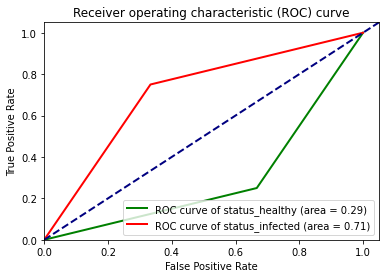

In [49]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(lb.fit_transform(testLabels), target_pred_prob[:, i],pos_label=1)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
colors = ['green', 'red']
targets = ['status_healthy','status_infected']
for i in range(2):
    plt.plot(fpr[i], tpr[i], color=colors[i],
             linewidth=2.0, label='ROC curve of {0} (area = {1:0.2f})'.format(targets[i], roc_auc[i]))
plt.plot([0, 1.05], [0, 1.05], color='navy', linewidth=2.0, linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

In [50]:
# 2.4.1 Logistic Regression Model

In [51]:
# Logistic Regression Model.
logit = models["logit"]
logit.fit(trainData,trainLabels)

LogisticRegression()

In [52]:
# 2.4.2 Predict the labels for the test data

In [53]:
# make predictions on our data and show a classification report
print("[INFO] evaluating...")
predictions = logit.predict(testData)
print(classification_report(testLabels,predictions,target_names=lb.classes_))

[INFO] evaluating...
                 precision    recall  f1-score   support

 Status_Healthy       0.80      0.67      0.73         6
Status_infected       0.60      0.75      0.67         4

       accuracy                           0.70        10
      macro avg       0.70      0.71      0.70        10
   weighted avg       0.72      0.70      0.70        10



In [54]:
# 2.4.3 Compute the confusion matrix for the test data

In [55]:
print("make predictions on our data and show a classification report")
predictionstest = logit.predict(datatest)
print(classification_report(labelstest,predictionstest,target_names=lb.classes_))

make predictions on our data and show a classification report
                 precision    recall  f1-score   support

 Status_Healthy       0.51      0.96      0.67      2760
Status_infected       0.69      0.09      0.16      2760

       accuracy                           0.53      5520
      macro avg       0.60      0.53      0.42      5520
   weighted avg       0.60      0.53      0.42      5520



Confusion matrix, without normalization
[[2645  115]
 [2503  257]]


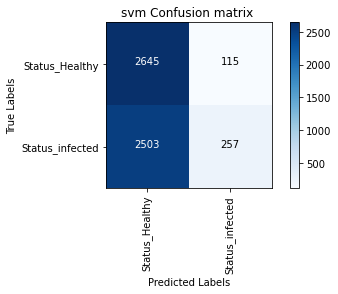

In [56]:
cnf_matrix = confusion_matrix(labelstest,predictionstest)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix,classes=lb.classes_,title='svm Confusion matrix ')
plt.show()

In [57]:
conf_matrix=confusion_matrix(labelstest,predictionstest)
print(conf_matrix)

[[2645  115]
 [2503  257]]


In [58]:
# 2.4.4 Compute the AUC

In [59]:
target_pred_prob = logit.predict_proba(testData)
logit_auc = roc_auc_score(testLabels,target_pred_prob[:,1], multi_class='ovr')
print(logit_auc)

0.875


In [60]:
# 2.4.5 Plot ROC

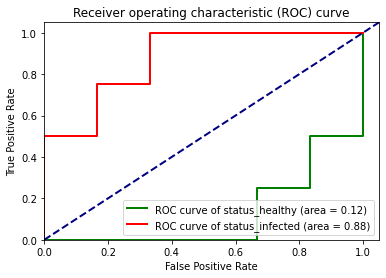

In [61]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(lb.fit_transform(testLabels), target_pred_prob[:, i],pos_label=1)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
colors = ['green', 'red']
targets = ['status_healthy','status_infected']
for i in range(2):
    plt.plot(fpr[i], tpr[i], color=colors[i],
             linewidth=2.0, label='ROC curve of {0} (area = {1:0.2f})'.format(targets[i], roc_auc[i]))
plt.plot([0, 1.05], [0, 1.05], color='navy', linewidth=2.0, linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

In [62]:
# 2.5.1 LDA model

In [63]:
print("Train the model with Linear Discriminant Analysis")
lda = models["lda"]
lda.fit(trainData,trainLabels)

Train the model with Linear Discriminant Analysis


LinearDiscriminantAnalysis()

In [64]:
# 2.5.2 Predict the labels for the test data

In [65]:
print("Makeing predictions and showing a classification report on our data")
predictions = lda.predict(testData)
print(classification_report(testLabels,predictions,target_names=lb.classes_))

Makeing predictions and showing a classification report on our data
                 precision    recall  f1-score   support

 Status_Healthy       1.00      0.67      0.80         6
Status_infected       0.67      1.00      0.80         4

       accuracy                           0.80        10
      macro avg       0.83      0.83      0.80        10
   weighted avg       0.87      0.80      0.80        10



In [66]:
# 2.5.2 Compute the confusion matrix

In [67]:
print(" Make predictions on our data and show a classification report")
predictionstest = lda.predict(datatest)
print(classification_report(labelstest,predictionstest,target_names=lb.classes_))

 Make predictions on our data and show a classification report
                 precision    recall  f1-score   support

 Status_Healthy       0.55      0.48      0.51      2760
Status_infected       0.54      0.61      0.58      2760

       accuracy                           0.55      5520
      macro avg       0.55      0.55      0.54      5520
   weighted avg       0.55      0.55      0.54      5520



The Confusion Matrix is :  [[2645  115]
 [2503  257]]
Confusion matrix, without normalization
[[1321 1439]
 [1063 1697]]


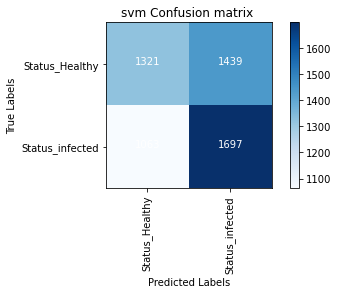

In [68]:
cnf_matrix = confusion_matrix(labelstest,predictionstest)
print("The Confusion Matrix is : " , conf_matrix)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix,classes=lb.classes_,title='svm Confusion matrix ')
plt.show()

In [69]:
# 2.5.4 Compute the AUC

In [70]:
print(" Linear Discriminated Analysis and It's COrresponding Area Under Curve")
target_pred_prob = lda.predict_proba(testData)
lda_auc = roc_auc_score(testLabels,target_pred_prob[:,1], multi_class='ovr')
print("LDA Area Under Curve : " , lda_auc)

 Linear Discriminated Analysis and It's COrresponding Area Under Curve
LDA Area Under Curve :  0.8333333333333334


In [71]:
# 2.5.5 Plot ROC

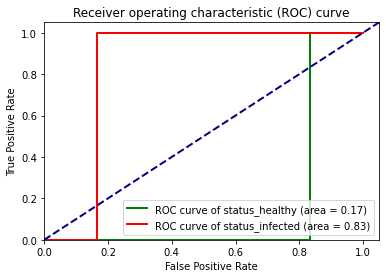

In [72]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(lb.fit_transform(testLabels), target_pred_prob[:, i],pos_label=1)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
colors = ['green', 'red']
targets = ['status_healthy','status_infected']
for i in range(2):
    plt.plot(fpr[i], tpr[i], color=colors[i],
             linewidth=2.0, label='ROC curve of {0} (area = {1:0.2f})'.format(targets[i], roc_auc[i]))
plt.plot([0, 1.05], [0, 1.05], color='navy', linewidth=2.0, linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

In [73]:
# 2.6.1 QDA model

In [74]:
# train the model
print("[INFO] using '{}' model".format("qda"))
qda = models["qda"]
qda.fit(trainData,trainLabels)

# The main cause of a warning is because of the elements of one vector are a linear function of the elements of another.

[INFO] using 'qda' model


C:\Users\acer\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis()

In [75]:
# 2.6.2 Predict the labels for the test data

In [76]:
print("make predictions on our data and show a classification report")
predictions = qda.predict(testData)
print(classification_report(testLabels,predictions,target_names=lb.classes_))

make predictions on our data and show a classification report
                 precision    recall  f1-score   support

 Status_Healthy       0.67      1.00      0.80         6
Status_infected       1.00      0.25      0.40         4

       accuracy                           0.70        10
      macro avg       0.83      0.62      0.60        10
   weighted avg       0.80      0.70      0.64        10



In [77]:
# 2.6.3 Compute the confusion matrix

In [78]:
print("make predictions on our data and show a classification report")
predictionstest = qda.predict(datatest)
print(classification_report(labelstest,predictionstest,target_names=lb.classes_))

make predictions on our data and show a classification report
                 precision    recall  f1-score   support

 Status_Healthy       0.49      0.95      0.65      2760
Status_infected       0.36      0.03      0.05      2760

       accuracy                           0.49      5520
      macro avg       0.43      0.49      0.35      5520
   weighted avg       0.43      0.49      0.35      5520



Confusion matrix, without normalization
[[2634  126]
 [2688   72]]


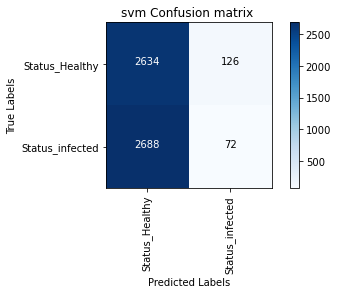

In [79]:
cnf_matrix = confusion_matrix(labelstest,predictionstest)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix,classes=lb.classes_,title='svm Confusion matrix ')
plt.show()

In [80]:
conf_matrix=confusion_matrix(labelstest,predictionstest)
print(conf_matrix)

[[2634  126]
 [2688   72]]


In [81]:
# 2.6.4 Compute the AUC

In [82]:
arget_pred_prob = qda.predict_proba(testData)
qda_auc = roc_auc_score(testLabels,target_pred_prob[:,1], multi_class='ovr')
print(qda_auc)

0.8333333333333334


In [83]:
# 2.6.5 Plot ROC

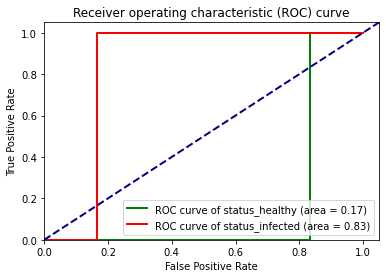

In [84]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(lb.fit_transform(testLabels), target_pred_prob[:, i],pos_label=1)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
colors = ['green', 'red']
targets = ['status_healthy','status_infected']
for i in range(2):
    plt.plot(fpr[i], tpr[i], color=colors[i],
             linewidth=2.0, label='ROC curve of {0} (area = {1:0.2f})'.format(targets[i], roc_auc[i]))
plt.plot([0, 1.05], [0, 1.05], color='navy', linewidth=2.0, linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

In [85]:
# 2.7.1 Boosting algorithm model

In [86]:
# train the model
print("[INFO] using '{}' model".format("ba"))
ba = models["gradient_boosing"]
ba.fit(trainData,trainLabels)

[INFO] using 'ba' model


GradientBoostingClassifier()

In [87]:
# 2.7.2 Predict the labels for the test data

In [88]:
# make predictions on our data and show a classification report
print("[INFO] evaluating...")
predictions = ba.predict(testData)
print(classification_report(testLabels,predictions,target_names=lb.classes_))

[INFO] evaluating...
                 precision    recall  f1-score   support

 Status_Healthy       1.00      1.00      1.00         6
Status_infected       1.00      1.00      1.00         4

       accuracy                           1.00        10
      macro avg       1.00      1.00      1.00        10
   weighted avg       1.00      1.00      1.00        10



In [89]:
# 2.7.3 Compute the confusion matrix

In [90]:
# make predictions on our data and show a classification report
print("[INFO] evluating...")
predictionstest = ba.predict(datatest)
print(classification_report(labelstest,predictionstest,target_names=lb.classes_))


[INFO] evluating...
                 precision    recall  f1-score   support

 Status_Healthy       0.65      0.86      0.74      2760
Status_infected       0.79      0.53      0.64      2760

       accuracy                           0.70      5520
      macro avg       0.72      0.70      0.69      5520
   weighted avg       0.72      0.70      0.69      5520



In [91]:
def plot_confusion_matrix(cm,classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=90)
    plt.yticks(tick_marks,classes)
    
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
    
    print(cm)
    
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],horizontalalignment="center",color="white" if cm[i,j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[2380  380]
 [1298 1462]]


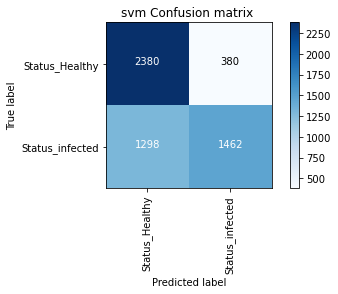

In [92]:
cnf_matrix = confusion_matrix(labelstest,predictionstest)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix,classes=lb.classes_,title='svm Confusion matrix ')
plt.show()

In [93]:
conf_matrix=confusion_matrix(labelstest,predictionstest)
print(conf_matrix)

[[2380  380]
 [1298 1462]]


In [94]:
# 2.7.4 Compute the AUC

In [95]:
target_pred_prob = ba.predict_proba(testData)
ba_auc = roc_auc_score(testLabels,target_pred_prob[:,1], multi_class='ovr')
print(ba_auc)

1.0


In [96]:
# 2.7.5 Plot ROC

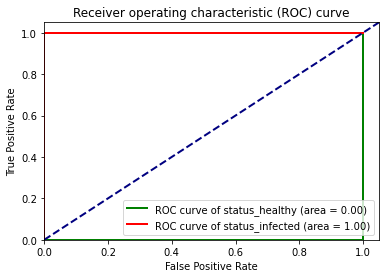

In [97]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(lb.fit_transform(testLabels), target_pred_prob[:, i],pos_label=1)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
colors = ['green', 'red']
targets = ['status_healthy','status_infected']
for i in range(2):
    plt.plot(fpr[i], tpr[i], color=colors[i],
             linewidth=2.0, label='ROC curve of {0} (area = {1:0.2f})'.format(targets[i], roc_auc[i]))
plt.plot([0, 1.05], [0, 1.05], color='navy', linewidth=2.0, linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

In [98]:
# 7  Out of all classifiers used in this assignment, which would you choose as a
#    final model for the malaria data?

In [99]:
# Random Forest model has a somewhat higher auc value than other models, 
# according to our observations in the model evaluation. As a result, 
# I feel Rain Forest Classification is far superior than other classification methods.